# Introduction
This is a simple exploratory notebook on a dataset we don't know much about. It is fairly simple and for concept purposes

In [1]:
# loading important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# reading in the data set and taking a peek at how it looks like
eda = pd.read_excel("EDA_Sample.xlsx")
eda.head()

,Id,City,State,Country,Gender\t,Profile_length,ActivityMonthlyDuration,HighAgreement,LowAgreement,Views,Fame,Questions,Answers,Comments,Edits,Tokens
0,11681441,NaN,NaN,France,male,NaN,0.3,0.0,0.0,2.0,1.0,1.0,NaN,NaN,NaN,1.0
1,6605265,Copenhagen,NaN,Denmark,male,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,1.0
2,6345204,Gowa,Sulawesi Selatan,Indonesia,male,300.0,14.1,0.0,0.0,2.0,1.0,NaN,NaN,NaN,NaN,2.0
3,8079496,Kursk,NaN,Russian Federation,male,NaN,12.9,0.0,0.0,4.0,6.0,1.0,NaN,NaN,NaN,1.0
4,8664722,Tehran,TEHRAN PROVINCE,"Iran, Islamic Republic of",male,NaN,17.5,0.0,0.0,4.0,1.0,1.0,2.0,NaN,NaN,2.0


In [3]:
eda.columns

Index(['Id', 'City', 'State', 'Country', 'Gender\t', 'Profile_length',
       'ActivityMonthlyDuration', 'HighAgreement', 'LowAgreement', 'Views',
       'Fame', 'Questions', 'Answers', 'Comments', 'Edits', 'Tokens'],
      dtype='object')

In [4]:
eda.rename({'Gender\t':'Gender'}, axis=1, inplace=True)

In [5]:
eda.shape

(163, 16)

In [6]:
# looking at the type distribution
dtypes_df = eda.dtypes.reset_index()
dtypes_df.columns = ['name', 'coltype']
dtypes_df.groupby('coltype').aggregate('count').reset_index()

,coltype,name
0,int64,1
1,float64,11
2,object,4


In [7]:
# null sum counts listings
missing_values = eda.isnull().sum().reset_index()
missing_values.columns = ['colname', 'nullcounts']
missing_values.head()

,colname,nullcounts
0,Id,0
1,City,51
2,State,74
3,Country,0
4,Gender,6


In [8]:
missing_values = missing_values.loc[missing_values.nullcounts > 0]
missing_values.head()

,colname,nullcounts
1,City,51
2,State,74
4,Gender,6
5,Profile_length,107
6,ActivityMonthlyDuration,6


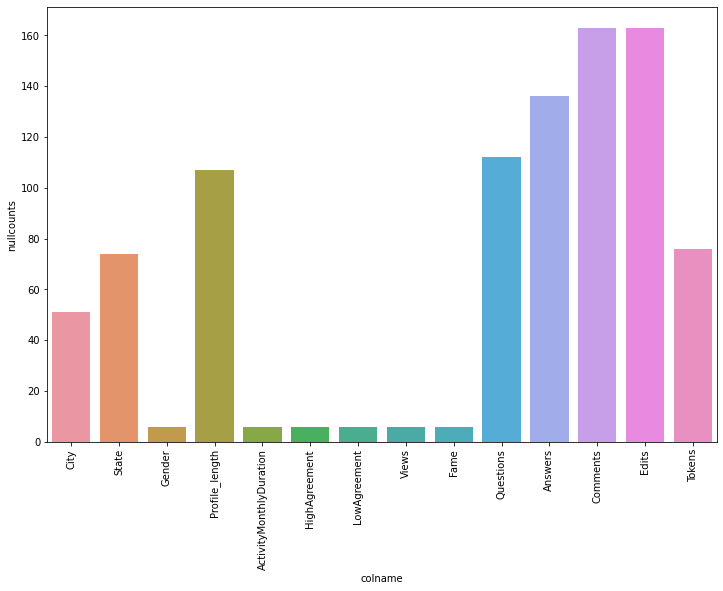

In [9]:
plt.figure(figsize=(12, 8))
sns.barplot(x='colname', y='nullcounts', data=missing_values)
# plt.bar(x=missing_values['colname'], height=missing_values['nullcounts'])
plt.xticks(rotation='vertical')
plt.show()

In [10]:
missing_values

,colname,nullcounts
1,City,51
2,State,74
4,Gender,6
5,Profile_length,107
6,ActivityMonthlyDuration,6
7,HighAgreement,6
8,LowAgreement,6
9,Views,6
10,Fame,6
11,Questions,112


In [11]:
# the shape is 163 and some columns are really missing everything (163 null columns)
empty_cols = missing_values.colname.loc[missing_values.nullcounts == eda.shape[0]]
empty_cols.values.tolist()

['Comments', 'Edits']

In [12]:
# we drop them
eda.drop(empty_cols, axis=1, inplace=True)
eda.shape

(163, 14)

Now, let us focus on a columns with few missing values i.e 6.
Let us start with Gender

In [13]:
# we may not be able to infer what gender is in a missing row, let's drop
g_rows = eda.loc[eda.Gender.isnull()]
eda.drop(g_rows.index, axis=0, inplace=True)

In [14]:
# re-collect missing values
missing_values = eda.isnull().sum().reset_index()
missing_values.columns = ['colname', 'nullcounts']
missing_values = missing_values.loc[missing_values.nullcounts>0]
missing_values

,colname,nullcounts
1,City,50
2,State,72
5,Profile_length,101
11,Questions,106
12,Answers,130
13,Tokens,70


We are now down to 6 missing-value columns!
The answers column is nearly empty, 130 of 154 values. 
So let us drop it injecting in a lot of 'unreal' data will be harmful for our model.
Since, "Questions" is related to answers and also has more than half of the values missing, we shall drop it too

In [15]:
eda.drop(['Questions', 'Answers'], axis=1, inplace=True)

We are down to 4 missing value columns

In [16]:
# lets look at city
# lets fill missing Cities with 'No City', this won't be good for our model though
eda.fillna({'City':'No City'}, inplace=True)

For State, we shall fill missing states with the most-common State under a given country. 
This may have a chance of being correct in real life.

In [17]:
# State
import collections
# finding uniques
srows = eda.loc[eda['State'].isnull()].index
countries_where_state_isnull = eda['Country'].loc[srows]
# make a unique list of these countrie
with_nostate_countries = list(collections.Counter(countries_where_state_isnull.values).keys())

In [18]:
# attempt to infer a state for the country
# hack a way around counting the most appearing state per country
edac = eda.copy() # make a copy
edac['states'] = eda['State'] # add a 'State' column to use in grouping
df_country_state = edac.groupby(['Country', 'State'])[['states']].aggregate('count').reset_index()
df_country_state.columns = ['Country', 'State', 'state_count']
df_country_state

,Country,State,state_count
0,Argentina,Provincia de Buenos Aires,1
1,Australia,QLD,1
2,Belgium,FLANDERS,1
3,Brazil,CE,1
4,Brazil,Minas Gerais,1
5,Brazil,RS,1
6,Brazil,SP,1
7,Canada,Alberta,2
8,Canada,Ontario,1
9,Chile,XIII REGIÓN METROPOLITANA DE SANTIAGO,2


In [19]:
# fill null states with most seen states;
edac = eda.copy()
for country in with_nostate_countries:
    # select zone for specific Country
    country_rows = df_country_state.loc[df_country_state['Country'] == country]
    if len(country_rows) == 0:
        state = country
    else:
        maxc = country_rows['state_count'].idxmax()
        state = country_rows.loc[maxc]['State']
    # print(country, ':', state)
    country_zone = edac.loc[edac['Country'] == country]
    indices = country_zone.loc[country_zone['State'].isnull()].index
    edac.loc[indices, 'State'] = state

edac.head()

,Id,City,State,Country,Gender,Profile_length,ActivityMonthlyDuration,HighAgreement,LowAgreement,Views,Fame,Tokens
0,11681441,No City,France,France,male,NaN,0.3,0.0,0.0,2.0,1.0,1.0
1,6605265,Copenhagen,Denmark,Denmark,male,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,6345204,Gowa,Sulawesi Selatan,Indonesia,male,300.0,14.1,0.0,0.0,2.0,1.0,2.0
3,8079496,Kursk,ROSTOV OBLAST,Russian Federation,male,NaN,12.9,0.0,0.0,4.0,6.0,1.0
4,8664722,Tehran,TEHRAN PROVINCE,"Iran, Islamic Republic of",male,NaN,17.5,0.0,0.0,4.0,1.0,2.0


In [20]:
# re-collect missing values
missing_values = edac.isnull().sum().reset_index()
missing_values.columns = ['colname', 'nullcounts']
missing_values = missing_values.loc[missing_values.nullcounts>0]
missing_values

,colname,nullcounts
5,Profile_length,101
11,Tokens,70


In [21]:
edac['Profile_length'].fillna(0, inplace=True)

Tokens remain with 70 null and they are our target. Almost half of them are missing.
If we drop ROWS with them, we shall have 87 rows of data only. All the work we've done above will nearly be in vain since we shall be dropping values we have hustled to fill.

The right thing to do is to drop the rows. However since this is just for simple exploration, lets fill missing tokens with the most occuring token-value.

In [22]:
# lets fill it with the most common token value;
# if we had lots of data, removing these rows would be good
vc=edac['Tokens'].value_counts().reset_index()
vc

,index,Tokens
0,1.0,42
1,2.0,12
2,3.0,6
3,4.0,5
4,6.0,4
5,5.0,3
6,8.0,2
7,26.0,2
8,9.0,2
9,7.0,2


In [23]:
maxx = vc['Tokens'].idxmax()
most_token = vc.loc[maxx]['index']
edac['Tokens'].fillna(most_token, inplace=True)

In [24]:
# for prediction, id wont be needed
edac.drop('Id', axis=1, inplace=True)
edac.head()

,City,State,Country,Gender,Profile_length,ActivityMonthlyDuration,HighAgreement,LowAgreement,Views,Fame,Tokens
0,No City,France,France,male,0.0,0.3,0.0,0.0,2.0,1.0,1.0
1,Copenhagen,Denmark,Denmark,male,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,Gowa,Sulawesi Selatan,Indonesia,male,300.0,14.1,0.0,0.0,2.0,1.0,2.0
3,Kursk,ROSTOV OBLAST,Russian Federation,male,0.0,12.9,0.0,0.0,4.0,6.0,1.0
4,Tehran,TEHRAN PROVINCE,"Iran, Islamic Republic of",male,0.0,17.5,0.0,0.0,4.0,1.0,2.0


In [25]:
# handling categorical data by transforming it into numbers

unq_City = list(collections.Counter(edac['City'].values).keys())
zipped = zip(unq_City, list(range(len(unq_City))))
data = dict(zipped)
edac['City'] = edac['City'].map(data)

unq_State = list(collections.Counter(edac['State'].values).keys())
zipped = zip(unq_State, list(range(len(unq_State))))
data = dict(zipped)
edac['State'] = edac['State'].map(data)

unq_Country = list(collections.Counter(edac['Country'].values).keys())
zipped = zip(unq_Country, list(range(len(unq_Country))))
data = dict(zipped)
edac['Country'] = edac['Country'].map(data)

unq_Gender = list(collections.Counter(edac['Gender'].values).keys())
zipped = zip(unq_Gender, list(range(len(unq_Gender))))
data = dict(zipped)
edac['Gender'] = edac['Gender'].map(data)

edac.head()

,City,State,Country,Gender,Profile_length,ActivityMonthlyDuration,HighAgreement,LowAgreement,Views,Fame,Tokens
0,0,0,0,0,0.0,0.3,0.0,0.0,2.0,1.0,1.0
1,1,1,1,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2,2,2,0,300.0,14.1,0.0,0.0,2.0,1.0,2.0
3,3,3,3,0,0.0,12.9,0.0,0.0,4.0,6.0,1.0
4,4,4,4,0,0.0,17.5,0.0,0.0,4.0,1.0,2.0


In [26]:
edac.dtypes.value_counts().reset_index()

,index,0
0,float64,7
1,int64,4


Next, Lets look at the correlation. It tell's us what kind of problem it is, what model you could use, etc.

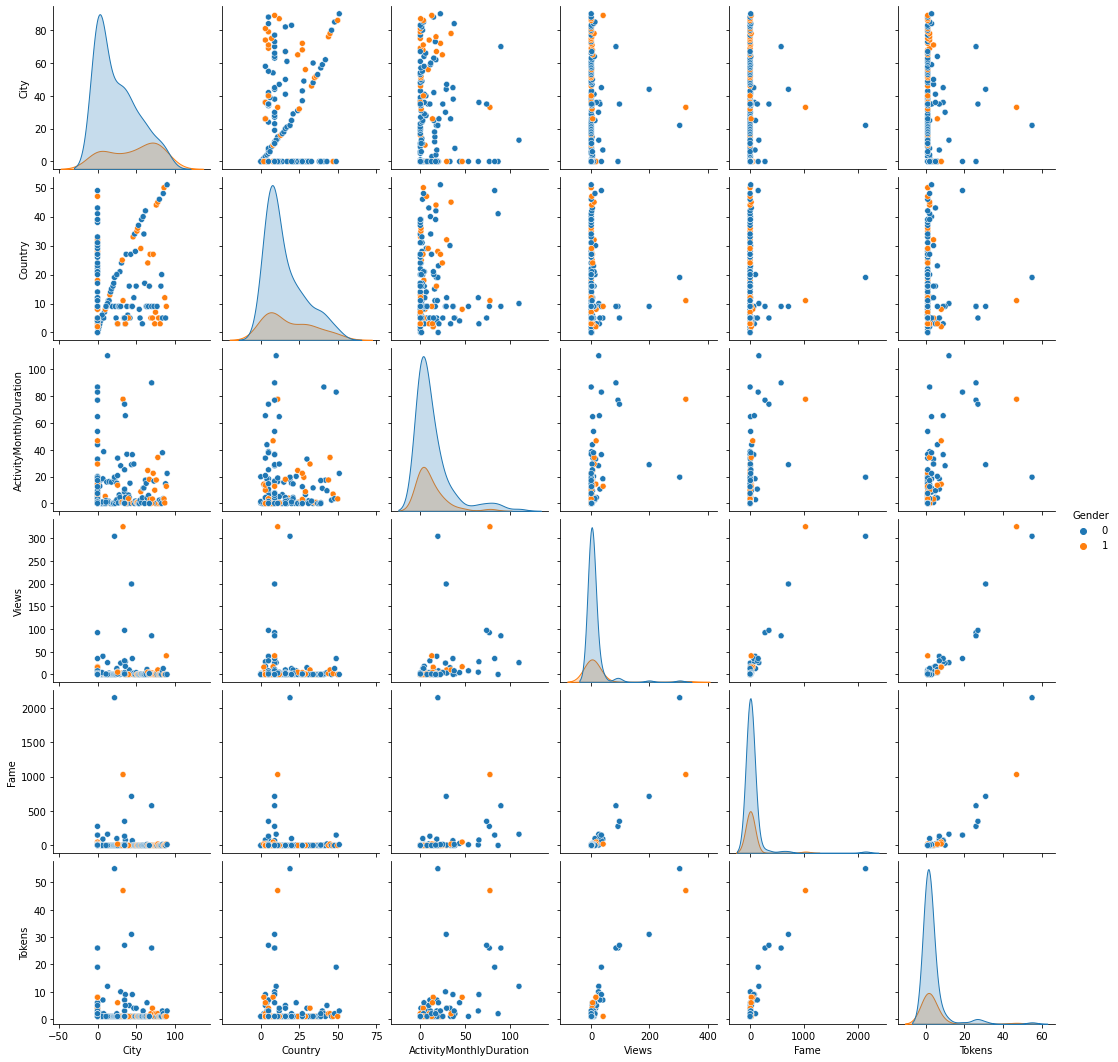

In [27]:
df_exp = edac[['City', 'Country', 'Gender', 'ActivityMonthlyDuration', 'Views', 'Fame', 'Tokens']]
sns.pairplot(df_exp, hue='Gender')

In [28]:
df_exp.corr()

,City,Country,Gender,ActivityMonthlyDuration,Views,Fame,Tokens
City,1.000000,0.135296,0.290116,-0.061541,0.020942,0.010196,-0.006667
Country,0.135296,1.000000,0.094977,-0.006194,-0.061912,-0.033095,-0.054270
Gender,0.290116,0.094977,1.000000,-0.044757,0.034512,-0.013496,-0.004978
ActivityMonthlyDuration,-0.061541,-0.006194,-0.044757,1.000000,0.416097,0.322875,0.552025
Views,0.020942,-0.061912,0.034512,0.416097,1.000000,0.923614,0.949485
Fame,0.010196,-0.033095,-0.013496,0.322875,0.923614,1.000000,0.907751
Tokens,-0.006667,-0.054270,-0.004978,0.552025,0.949485,0.907751,1.000000


Despite our messy data cleanup, we managed to keep some good linear-correlation in the data.
By looking at the the Tokens field, we see that.
- City and Gender have the least correlation
- The Country also matters less

We can conclude that Tokens depend on Views, Fame and ActivityMonthlyDuration.
With this strong linear correlation (up to 0.94), a linear model is good for this problem.